In [1]:
############################################################
# Implementation of the cal_example_zerox.m
# Used to verify the code base works without errors.
############################################################

import numpy as np
import matplotlib.pyplot as plt
import arviz

from mcmc.mcmc import MCMC
from mcmc.data import Data
# from mcmc.chain import Chain
from mcmc.parameter import Parameter

from mcmc.models.kennedyohagan.model1 import Model

# Setup Model

In [2]:
#################
##### MODEL #####
#################

model = Model(
    params={
        'theta': Parameter(
            'theta',
            np.array([0.4]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_eta': Parameter(
            'omega_eta',
            np.array([
                np.exp(-50/4), 
                np.exp(-7/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_delta': Parameter(
            'omega_delta',
            np.array([
                np.exp(-2/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'lambda_eta': Parameter(
            'lambda_eta',
            np.array([1]),
            positive=True,
        ),
        'lambda_delta': Parameter(
            'lambda_delta',
            np.array([30]),
            positive=True,
        ),
        'lambda_epsilon': Parameter(
            'lambda_epsilon',
            np.array([1000]),
            positive=True,
        ),
        'lambda_epsilon_eta': Parameter(
            'lambda_epsilon_eta',
            np.array([10000]),
            positive=True,
        )
    }
)

# Setup Data

In [3]:

################
##### DATA #####
################

DATAFIELD = np.loadtxt('data/simple_field.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/simple_comp.csv', delimiter=',', dtype=np.float32)

xf = np.reshape(DATAFIELD[:, 0], (-1, 1))
xc = np.reshape(DATACOMP[:, 0], (-1,1))
tc = np.reshape(DATACOMP[:, 1], (-1,1))
yf = np.reshape(DATAFIELD[:, 1], (-1,1))
yc = np.reshape(DATACOMP[:, 2], (-1,1))



#Standardize full response using mean and std of yc
yc_mean = np.mean(yc)
yc_std = np.std(yc)
x_min = min(xf.min(), xc.min())
x_max = max(xf.max(), xc.max())
t_min = tc.min()
t_max = tc.max()

xf_normalized = (xf - x_min)/(x_max - x_min)
xc_normalized = (xc - x_min)/(x_max - x_min)
# tc_normalized = np.zeros_like(tc)
# for k in range(tc.shape[1]):
#     tc_normalized[:, k] = (tc[:, k] - np.min(tc[:, k]))/(np.max(tc[:, k]) - np.min(tc[:, k]))
tc_normalized = (tc - t_min)/(t_max - t_min)
yc_standardized = (yc - yc_mean)/yc_std
yf_standardized = (yf - yc_mean)/yc_std

data = Data(
    x_c = xc_normalized, 
    t   = tc_normalized,
    y   = yc_standardized,
    x_f = xf_normalized,
    z   = yf_standardized
)

# Run MCMC

In [4]:
################
##### MCMC #####
################

proposal_widths = {
    'theta': [0.25],
    'omega_eta': [0.000001, 0.3],
    'omega_delta': [0.7],
    'lambda_eta': 0.15,
    'lambda_epsilon_eta': 10000,
    'lambda_delta': 40,
    'lambda_epsilon': 5000
}

mcmc = MCMC(
    max_iter = 5000,
    model = model,
    data = data,
    proposal_widths = proposal_widths
)

mcmc.run()

['theta_0', 'omega_eta_0', 'omega_eta_1', 'omega_delta_0', 'lambda_eta_0', 'lambda_delta_0', 'lambda_epsilon_0', 'lambda_epsilon_eta_0']
Iteration: 0. Log-Posterior: 698.1114547891026
{'theta_0': 0.4, 'omega_eta_0': 3.7266532e-06, 'omega_eta_1': 0.17377394, 'omega_delta_0': 0.60653067, 'lambda_eta_0': 1.0, 'lambda_delta_0': 30.0, 'lambda_epsilon_0': 1000.0, 'lambda_epsilon_eta_0': 10000.0}
Iteration: 50. Log-Posterior: 850.3980566804414
{'theta_0': 0.5051097, 'omega_eta_0': 3.6782178e-06, 'omega_eta_1': 0.34941834, 'omega_delta_0': 0.99942464, 'lambda_eta_0': 0.36664253, 'lambda_delta_0': 33.143005, 'lambda_epsilon_0': 8238.455, 'lambda_epsilon_eta_0': 56086.656}
Iteration: 100. Log-Posterior: 854.7791996617024
{'theta_0': 0.5636357, 'omega_eta_0': 2.9495327e-06, 'omega_eta_1': 0.39813077, 'omega_delta_0': 0.84439325, 'lambda_eta_0': 0.249148, 'lambda_delta_0': 24.895527, 'lambda_epsilon_0': 6280.525, 'lambda_epsilon_eta_0': 87671.41}
Iteration: 150. Log-Posterior: 855.3629994875342
{'

# Analysis

In [5]:
####################
##### ANALYSIS #####
####################

mcmc.chain._chain['theta_0'] = mcmc.chain._chain['theta_0']*(t_max - t_min) + t_min
output = mcmc.chain._chain
for item, value in output.items():
    print(item, np.mean(value), np.min(value), np.max(value))


arviz.summary(mcmc.chain._chain)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


theta_0 0.42581172539696416 0.3767087170519261 0.4769820967598619
omega_eta_0 3.282099655643833e-06 1.7658983608725976e-07 1.093862192647066e-05
omega_eta_1 0.4139042369157076 0.16225843131542206 0.55765300989151
omega_delta_0 0.6955634655726841 0.0008909148164093494 0.9999067187309265
lambda_eta_0 0.2520960102379322 0.11849573254585266 0.9425860643386841
lambda_delta_0 36.78142564754486 12.045365333557129 77.72004699707031
lambda_epsilon_0 9754.447290527343 1000.0 21082.09375
lambda_epsilon_eta_0 79508.781459375 10000.0 118488.84375


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.426,0.013,0.402,0.449,0.000,0.000,1349.0,1272.0,NaN
omega_eta_0,0.000,0.000,0.000,0.000,0.000,0.000,15.0,41.0,NaN
omega_eta_1,0.414,0.043,0.337,0.496,0.006,0.004,50.0,256.0,NaN
omega_delta_0,0.696,0.304,0.114,1.000,0.025,0.018,105.0,121.0,NaN
lambda_eta_0,0.252,0.066,0.161,0.348,0.008,0.006,58.0,241.0,NaN
lambda_delta_0,36.781,9.520,20.395,54.839,0.351,0.249,750.0,1269.0,NaN
lambda_epsilon_0,9754.447,2956.612,4631.664,15680.428,207.654,152.722,218.0,303.0,NaN
lambda_epsilon_eta_0,79508.781,10481.383,63064.270,99904.164,1048.677,751.587,104.0,158.0,NaN


In [6]:
plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

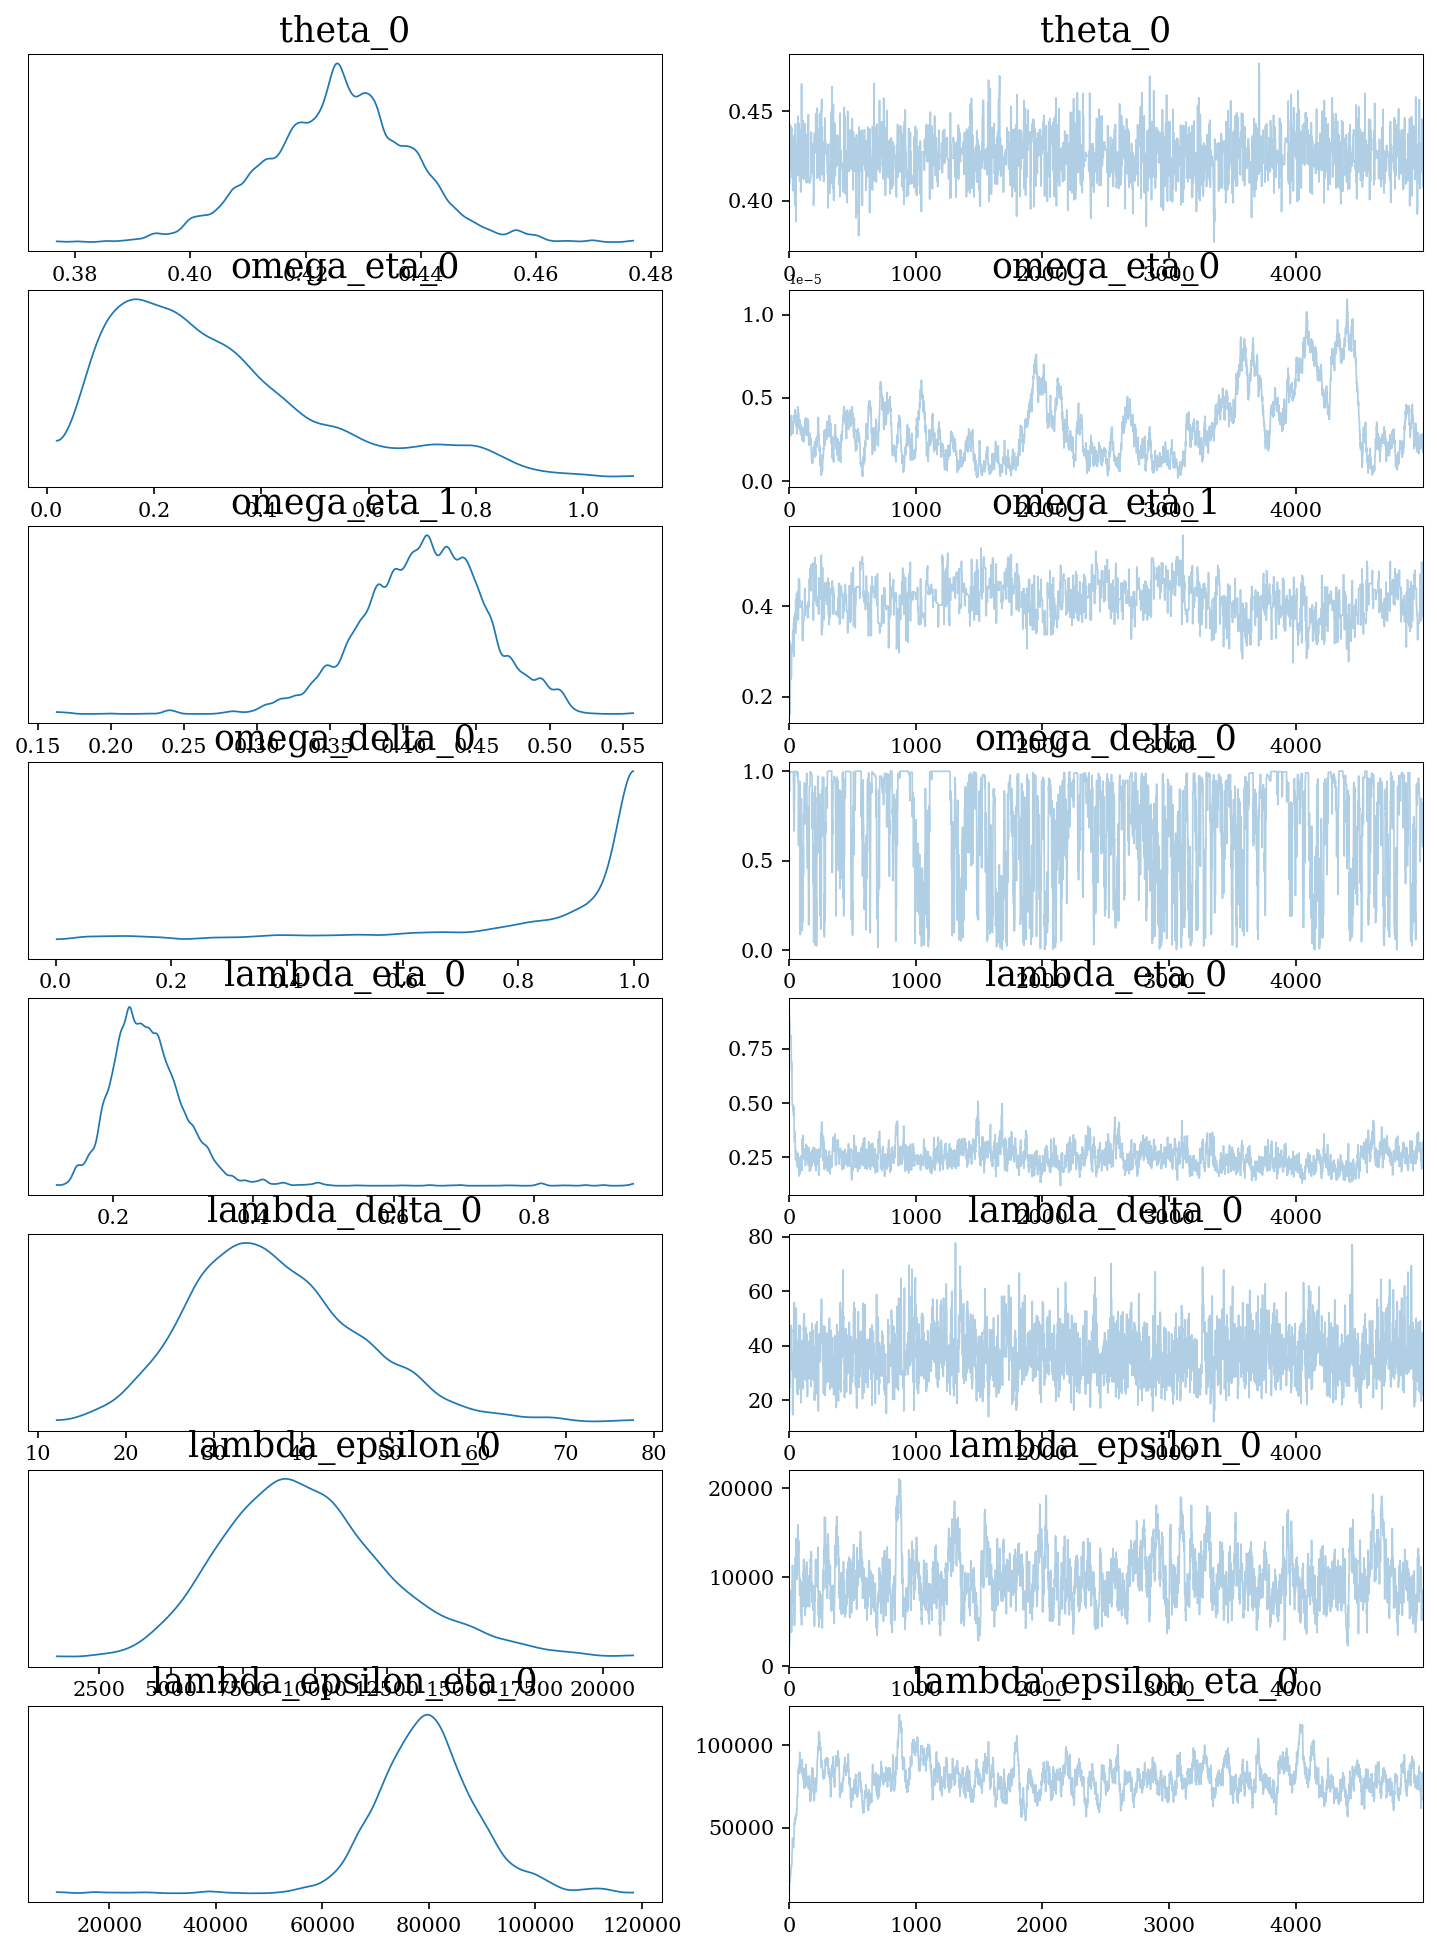

In [7]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        mcmc.chain._chain
    )